# Determine relative position between images
Use opecv's homography function to approximate the relative location between the images

Because homography assumes all points are planar, this results in 'ghosting' when using this method to stitch images

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

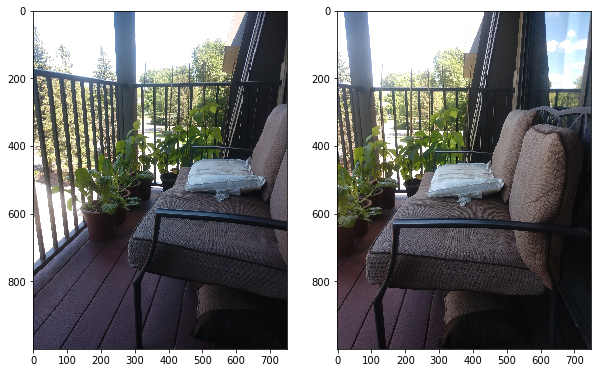

In [2]:
scale = .25

image_left = cv2.imread("images/patio_left.jpg")
image_right = cv2.imread("images/patio_right.jpg")
image_left = cv2.resize(image_left,(0,0),fx=scale,fy=scale)
image_right = cv2.resize(image_right,(0,0),fx=scale,fy=scale)
plt.rcParams['figure.figsize'] = [10,10]
plt.subplot(1,2,1)
plt.imshow(image_left[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(image_right[:,:,::-1])
plt.show()

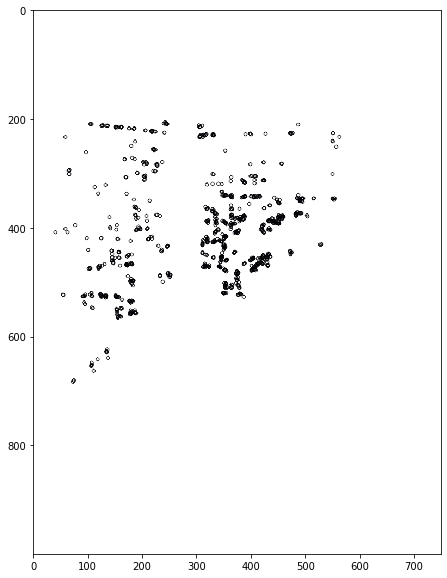

In [3]:
orb = cv2.ORB_create(nfeatures=1000)
image_left_gray = cv2.cvtColor(image_left,cv2.COLOR_BGR2GRAY)
kps = orb.detect(image_left_gray)
kps, descs = orb.compute(image_left_gray,kps)

#left_kp = image_left.copy()
left_kp = np.zeros_like(image_left)+255
left_kp = cv2.drawKeypoints(left_kp,kps,left_kp,cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(left_kp[:,:,::-1])

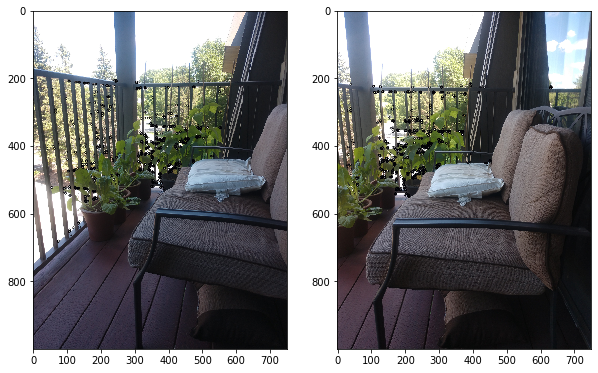

In [4]:
left_gray = cv2.cvtColor(image_left,cv2.COLOR_BGR2GRAY)
right_gray = cv2.cvtColor(image_right,cv2.COLOR_BGR2GRAY)
orb = cv2.ORB_create(nfeatures=1000)

kps1, descs1 = orb.detectAndCompute(left_gray,None)
kps2, descs2 = orb.detectAndCompute(right_gray,None)

left_with_kps = image_left.copy()
right_with_kps = image_right.copy()

plt.subplot(1,2,1)
plt.imshow(cv2.drawKeypoints(left_with_kps,kps1,left_with_kps,cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)[:,:,::-1])

plt.subplot(1,2,2)
plt.imshow(cv2.drawKeypoints(right_with_kps,kps2,right_with_kps,cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)[:,:,::-1])

plt.show()

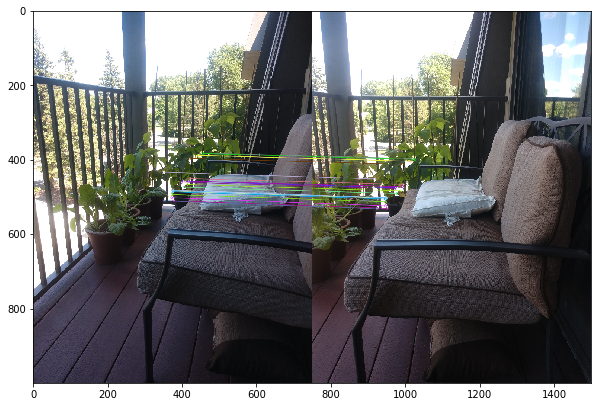

True

In [5]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = bf.match(descs1,descs2)
matches = sorted(matches, key=lambda x:x.distance)

img3 = cv2.drawMatches(image_left,kps1, image_right,kps2, matches[:20],None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3[:,:,::-1])
plt.show()

cv2.imwrite("matches.jpg",img3)

# Now find the 3d orientation between them

Found 216 matches from 1000


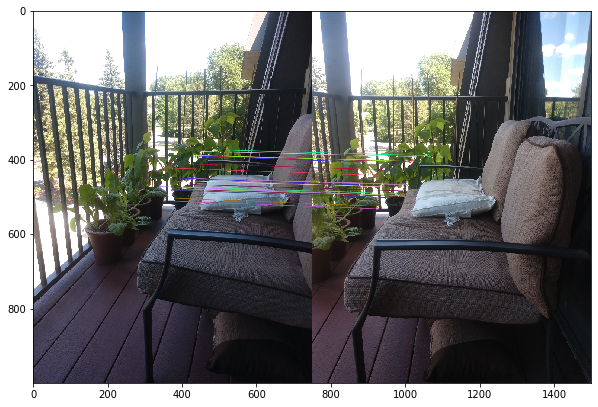

True

In [6]:
MIN_MATCH_COUNT = 10
#FLANN_INDEX_KDTREE = 1
#index_params = {"algorithm":FLANN_INDEX_KDTREE,"trees":5} # for SIFT
#index_params = {"algorithm":"FLANN_INDEX_LSH", "table number": 6, "key_size": 12, "multi_probe_level": 1}
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                  table_number =12, # 12
                  key_size = 10,     # 20
                  multi_probe_level = 2) #2
search_params = {"checks":100}

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(descs1, descs2, k=2)
#matches = [m[0] for m in matches]


# keep good matches
good = [m for m,n in matches if m.distance<0.7*n.distance]
print(f"Found {len(good)} matches from {len(matches)}")

    
img3 = cv2.drawMatches(image_left,kps1, image_right,kps2, good[:20],None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3[:,:,::-1])
plt.show()
cv2.imwrite("matches.jpg",img3)

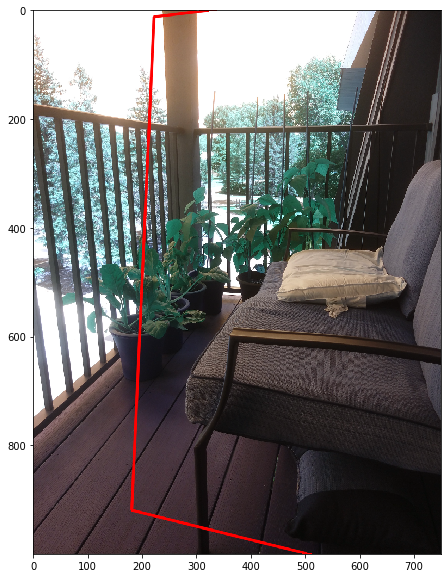

In [7]:
matches= good
if len(matches) > MIN_MATCH_COUNT:
    src_points = np.float32([ kps2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    dst_points = np.float32([ kps1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    
    
    M, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    
    h,w,d = image_right.shape
    pts = np.float32([ [0,0], [0,h-1], [w-1,h-1], [w-1,0]]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    imgOut = image_left.copy()
    imgOut = cv2.polylines(imgOut, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
    #imgOut = cv2.fillPoly(imgOut, [dst.astype(np.int32)],(255,255,0),8)
    plt.imshow(imgOut)
else:
    print("Not enough matches found")

draw_params = {"matchColor": (0,255,2), "singlePointColor": None, "matchesMask": matchesMask, "flags":2}

In [8]:
width = int(dst[:,:,0].max())
height = image_left.shape[0]

uint8
(1000, 1055, 3)


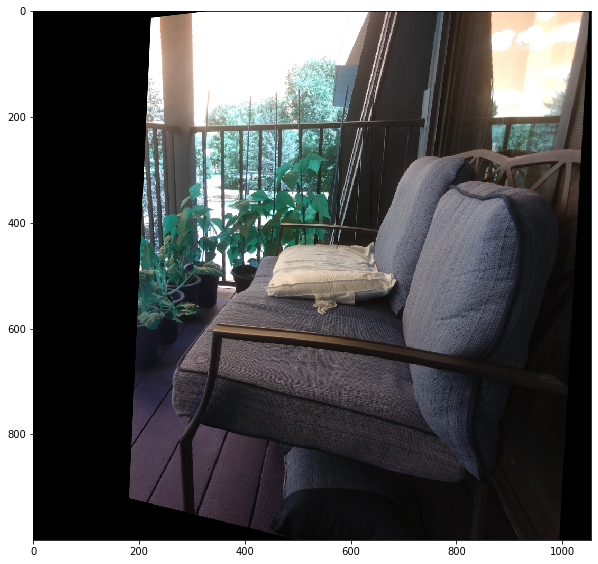

In [9]:
#out = np.zeros((height,width,3),dtype=np.float32)
out = cv2.warpPerspective(image_right,M,(width,height))
plt.imshow(out)
print(out.dtype)
print(out.shape)

(1000, 1055, 3)


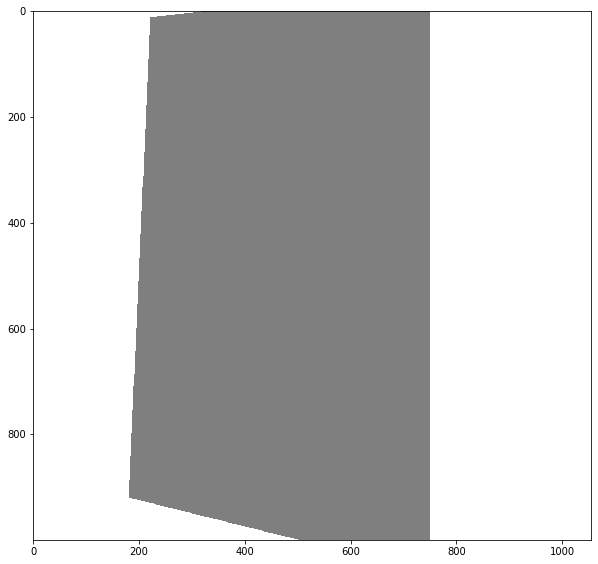

In [10]:
mask = np.ones((height,width,3),dtype=np.float32)
mask = cv2.fillPoly(mask, [dst.astype(np.int32)],(.5,.5,.5),8)
mask[:,image_left.shape[1]:] = 1
plt.imshow(mask)
print(mask.shape)

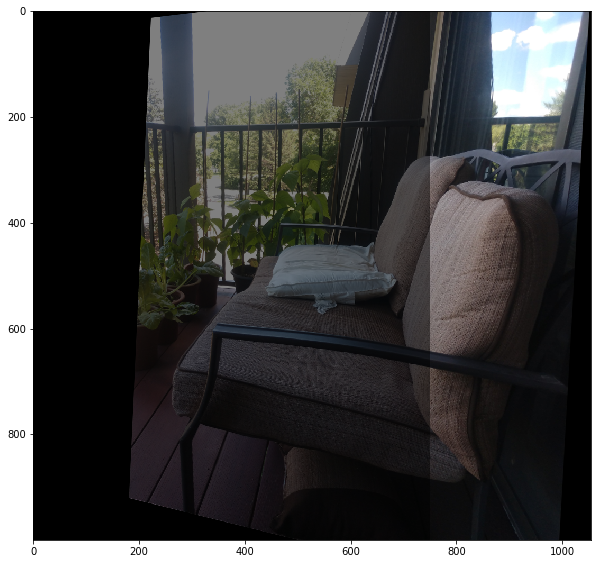

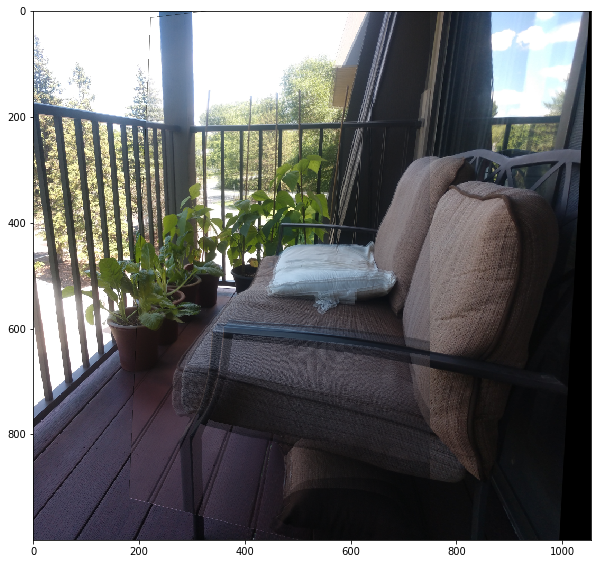

In [11]:
out = mask*(out.astype(np.float32))
plt.imshow(out[:,:,::-1]/255)
plt.show()
out[:,:image_left.shape[1],:] += mask[:,:image_left.shape[1]]*image_left.astype(np.float32)
out = out / 255.
plt.imshow(out[:,:,::-1])
plt.show()